/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(sorted(unique_bonds)), 4)
/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyobjects.py:600: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  guessed = np.asarray(guessed, dtype=np.bool)


[[1.38, 1.87, 2.39, 2.63, 2.9, 2.614, 3.0, 2.71, 2.83, 2.81, 3.15, 3.36, 2.64, 2.71, 2.68, 2.67, 2.57, 2.62, 2.71, 2.69, 2.8, 2.79, 2.72, 2.85, 2.63, 2.72, 2.92, 2.76, 2.56, 2.61, 2.86, 2.85, 2.6, 3.34, 3.7, 4.0, 4.1, 4.2, 4.84, 4.9, 4.7, 5.2, 5.11, 4.92, 5.34, 5.26, 6.0], [1.38, 1.87, 2.39, 2.63, 2.9, 2.614, 3.0, 2.71, 2.83, 2.81, 3.15, 3.36, 2.64, 2.71, 2.68, 2.67, 2.57, 2.62, 2.71, 2.69, 2.8, 2.79, 2.72, 2.85, 2.63, 2.72, 2.92, 2.76, 2.56, 2.61, 2.86, 2.85, 2.6, 3.34, 3.7, 4.0, 4.1, 4.2, 4.84, 4.9, 4.7, 5.2, 5.11, 4.92, 5.34, 5.26, 6.0]] [[1.4330104624346274, 2.2535224543782957, 2.0947265607992867, 2.4147384478377343, 2.9605980690766582, 2.5748302383557204, 3.0080674178503166, 2.7186048025505523, 2.2592773574457934, 2.9986752883853054, 3.059502923219809, 3.2050292245528236, 2.2220608294891706, 2.233517300037721, 2.3214925303843614, 2.0031326706681014, 2.039549193942858, 2.1795608634432075, 2.4537061459896554, 2.2050769545524114, 2.2256378721348016, 2.066553733003808, 2.1525230613236

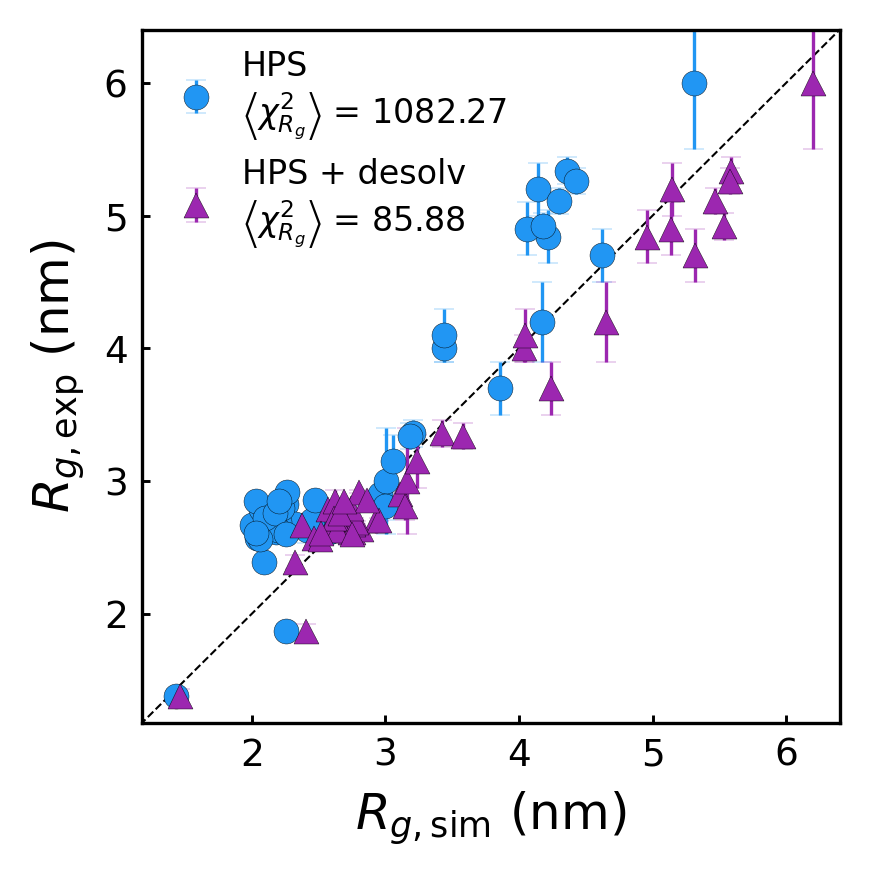

In [86]:
import os, sys
import numpy as np
import pandas as pd
import mdtraj as md
import MDAnalysis as mda
import matplotlib.pyplot as plt

def boxave(x):
    nbox = 5
    npoint = len(x)
    dbox = int(npoint / nbox)
    res = np.zeros(nbox)
    for i in range(nbox):
        res[i] = np.sqrt(np.mean(x[i * dbox:(i + 1) * dbox]**2))
    return np.sqrt(np.mean(x**2)), np.std(res) / np.sqrt(nbox)

options = ['hps', '0.33_0.06_1.0']
clist = ['#2196F3', '#9C27B0']
flist = ['o', '^', 's', 'd']

proteins = pd.read_pickle('../seq/allproteins.pkl')
residues = pd.read_csv('../residues.csv').set_index('one', drop=False)
df = pd.read_csv('../residues.csv').set_index('three')

RG_SIM, RG_EXP, CHI2, ERR_EXP, ERR_SIM = [], [], [], [], []
for i in range(len(options)):

    option = options[i]
    rgSim, rgExp, chi2, errExp, errSim = [], [], [], [], []
    for name in proteins.index:
        folder = '../rg/traj_hps/{:s}/'.format(name)
        if not os.path.exists(folder):
            continue
        prot = proteins.loc[name]
        if np.isnan(prot.expRg):
            continue
        gsdfile = '../rg/{:s}{:s}.gsd'.format(folder, option)
        dcdfile = '../rg/{:s}{:s}.dcd'.format(folder, option)
        u = mda.Universe(gsdfile, dcdfile)
        at = u.select_atoms('all')
        nlen = len(u.trajectory)
        natoms = at.n_atoms
        length = int(natoms * (natoms - 1) / 2)
        rg = np.zeros(nlen)
        for tdx, ts in enumerate(u.trajectory):
            mda.lib.mdamath.make_whole(at)
            rg[tdx] = at.radius_of_gyration()
        averg, errrg = boxave(rg[100:])

        rgSim.append(averg)
        rgExp.append(prot.expRg)
        errExp.append(prot.expRgErr)
        errSim.append(errrg)
        chi2.append(np.power((prot.expRg-averg)/prot.expRgErr, 2))

    RG_SIM.append(rgSim)
    RG_EXP.append(rgExp)
    ERR_EXP.append(errExp)
    ERR_SIM.append(errSim)
    CHI2.append(chi2)

fig, ax = plt.subplots(1, 1, figsize=[3., 3.], facecolor='w', dpi=300)
plt.plot([0, 10], [0, 10], 'k--', linewidth=0.5)
for i in range(len(options)):
    if options[i] == 'hps':
        label = 'HPS\n'+r'$\left\langle\chi_{R_g}^2\right\rangle$ = %.2f'%(np.mean(CHI2[i]))
    else:
        label = 'HPS + desolv\n'+r'$\left\langle\chi_{R_g}^2\right\rangle$ = %.2f'%(np.mean(CHI2[i]))
    plt.errorbar(x=RG_SIM[i], y=RG_EXP[i], yerr=ERR_EXP[i], fmt=flist[i], ecolor=clist[i],\
                 color=clist[i], elinewidth=0.8, capsize=2.5, capthick=0.5, markersize=6,\
                 label=label, markeredgecolor='k', markeredgewidth=0.1)
print(RG_EXP, RG_SIM)
xmin = np.nanmin(RG_EXP+RG_SIM) - 0.2
xmax = np.nanmax(RG_EXP+RG_SIM) + 0.2
plt.xlabel(r'$R_{g, \mathregular{sim}}$ (nm)', fontsize=12)
plt.ylabel(r'$R_{g, \mathregular{exp}}$ (nm)', fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
leg = plt.legend(fontsize=8, loc='upper left', handletextpad=0.4, frameon=False, borderpad=0.1)
# leg.get_frame().set_linewidth(0.4)

plt.savefig(f"../../figures/param/hps+desolvation.svg", format="svg", bbox_inches='tight')
plt.show()

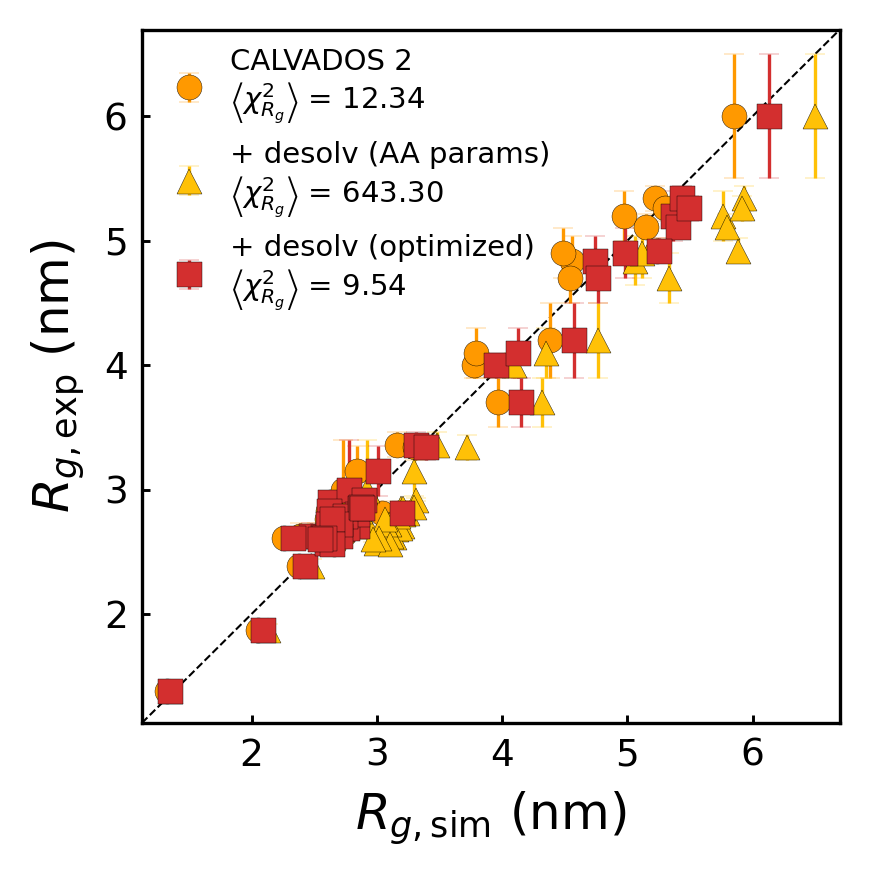

In [8]:
import os, sys
import numpy as np
import pandas as pd
import mdtraj as md
import MDAnalysis as mda
import matplotlib.pyplot as plt
from decimal import Decimal

def calcRg(df, name, prot, trajfile, residues):

    # load and center gsd file
    top = md.Topology()
    chain = top.add_chain()
    for resname in prot.fasta:
        res = top.add_residue(residues.loc[resname, 'three'], chain)
        top.add_atom(residues.loc[resname, 'three'], element=md.element.carbon, residue=res)
    for i in range(len(prot.fasta)-1):
        top.add_bond(top.atom(i),top.atom(i+1))
    traj = md.load('../rg/traj/{:s}/{:s}'.format(name, trajfile))[100:]
    traj.top = top
    traj = traj.image_molecules(inplace=False, anchor_molecules=[set(traj.top.chain(0).atoms)], make_whole=True)
    traj.center_coordinates()
    traj.xyz += traj.unitcell_lengths[0,0]/2

    residue = [res.name for res in traj.top.atoms]
    masses = df.loc[residue, 'MW'].values
    masses[0] += 2
    masses[-1] += 16
    # calculate the center of mass
    cm = np.sum(traj.xyz*masses[np.newaxis,:,np.newaxis],axis=1)/masses.sum()
    # calculate residue-cm distances
    si = np.linalg.norm(traj.xyz - cm[:,np.newaxis,:],axis=2)
    # calculate rg
    rgarray = np.sqrt(np.sum(si**2*masses,axis=1)/masses.sum())
    #rg = np.sqrt( np.power(rgarray, 2).mean() )
    rg = rgarray.mean()
    chi2_rg = np.power((prot.expRg-rg)/prot.expRgErr, 2)
    #chi2_rg = np.power((prot.expRg-rg)/(prot.expRg*0.03),2)
    return rg, prot.expRg, chi2_rg

options = ['CALVADOS2', '0.33_0.06_1.0', '0.3_0.03_1.31']
clist = ["#FF9900", "#FFC107", '#D32F2F']
flist = ['o', '^', 's', 'd']

proteins = pd.read_pickle('../seq/allproteins.pkl')
residues = pd.read_csv('../residues.csv').set_index('one', drop=False)
df = pd.read_csv('../residues.csv').set_index('three')

RG_SIM, RG_EXP, CHI2, ERR_EXP = [], [], [], []
for i in range(len(options)):

    option = options[i]
    trajfile = '{:s}.gsd'.format(option)
    RGSim, RGExp, chi2, errExp = [], [], [], []
    for name in proteins.index:
        if not os.path.exists('../rg/traj/{:s}/'.format(name)):
            continue
        if np.isnan(proteins.loc[name].expRg):
            continue
        rgSim, rgExp, chi2_rg = calcRg(df, name, proteins.loc[name], trajfile, residues)
        if rgSim > 100:
            continue
        RGSim.append(rgSim)
        RGExp.append(rgExp)
        chi2.append(chi2_rg)
        errExp.append(proteins.loc[name].expRgErr)

    RG_SIM.append(RGSim)
    RG_EXP.append(RGExp)
    ERR_EXP.append(errExp)
    CHI2.append(chi2)

fig, ax = plt.subplots(1, 1, figsize=[3., 3.], facecolor='w', dpi=300)
plt.plot([0, 10], [0, 10], 'k--', linewidth=0.5)
for i in range(len(options)):
    if options[i] == 'CALVADOS2':
        label = 'CALVADOS 2\n'+r'$\left\langle\chi_{R_g}^2\right\rangle$ = %.2f'%(np.mean(CHI2[i]))
    else:
        param = options[i].split('_')
        alpha_b, alpha_w, ratio = param[0], param[1], param[2]
        # plabel = r'$\alpha_{\mathregular{b}} = %s, \alpha_{\mathregular{w}} = %s, \varepsilon = %s$'%(alpha_b, alpha_w, str((Decimal(ratio)*Decimal('0.2')).normalize()))
        if i == 1:
            plabel = '+ desolv (AA params)'
        else:
            plabel = '+ desolv (optimized)'
        label = plabel+'\n'+r'$\left\langle\chi_{R_g}^2\right\rangle$ = %.2f'%(np.mean(CHI2[i]))
    plt.errorbar(x=RG_SIM[i], y=RG_EXP[i], yerr=ERR_EXP[i], fmt=flist[i], ecolor=clist[i],\
                 color=clist[i], elinewidth=0.8, capsize=2.5, capthick=0.5, markersize=6,\
                 label=label, markeredgecolor='k', markeredgewidth=0.1)
xmin = min(np.min(np.array(RG_EXP)), np.min(np.array(RG_SIM))) - 0.2
xmax = max(np.max(np.array(RG_EXP)), np.max(np.array(RG_SIM))) + 0.2
plt.xlabel(r'$R_{g, \mathregular{sim}}$ (nm)', fontsize=12)
plt.ylabel(r'$R_{g, \mathregular{exp}}$ (nm)', fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
leg = plt.legend(fontsize=7, loc='upper left', handletextpad=0.4, frameon=False, borderpad=0.1)
# leg.get_frame().set_linewidth(0.4)

plt.savefig(f"../../figures/param/calvados+desolvation.svg", format="svg", bbox_inches='tight')
plt.show()

In [2]:
# fit binodal curve based on Flory-Huggins Theory
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def critical(n=1):
    """
    Calculates the critical point for a given polymer length.

    Equation (3) in the paper.

    I don't understand why this works or where these functional
    forms come from?

    Parameters
    -----------------
    n : int
        Polymer length.


    Returns
    ---------------
    np.array of l=2
        Returns an numpy array with 2 elements
        [0] - volume fraction at critical point
        [1] - chi at critical point

    """

    x_c = 0.5 * np.power(1. + 1. / np.sqrt(n), 2)
    phi_c = 1. / (1. + np.sqrt(n))
    return np.array([phi_c, x_c])

def GL_binodal(x, n=1):
    """
    GL = Ginzerberg-Landau

    """

    crit = critical(n)
    x_c = crit[1]
    phi_c = crit[0]

    if not np.array(x).shape:
        if x > x_c:
            t1 = phi_c
            t2 = np.sqrt(3. * (x - x_c) / (2. * np.power(x_c, 2) * np.sqrt(n)))
            return np.array([t1 + t2, t1 - t2, x])
        else:
            raise ValueError('interaction strength too small - no LLPS!')
    else:
        if max(x) < x_c:
            raise ValueError('interaction strength too small - no LLPS!')
        else:
            x = np.array(x)
            x = x[x >= x_c]
            t1 = phi_c
            t2 = np.sqrt(3. * (x - x_c) / (2. * np.power(x_c, 2) * np.sqrt(n)))
            return np.array([t1 + t2, t1 - t2, x])

def binodal(x, n=1, iteration=5, UseImprovedMap=True):

    assert iteration >= 0
    crit = critical(n)
    x_c = crit[1]
    phi_c = crit[0]
    gamma = 1. - 1. / n

    if n == 1:

        guess = GL_binodal(x)

        pp = guess[0]
        xx = guess[2]

        if UseImprovedMap:

            for _ in range(iteration):
                ee = np.exp(- 2 * xx * pp + xx)
                pp = (2. * xx * pp * ee - 1. - ee) / (2. * xx * ee - (1. + ee)**2)

        else:

            for _ in range(iteration):
                ee = np.exp(- 2 * xx * pp + xx)
                pp = 1 / (1 + ee)

        return np.array([pp, 1 - pp, xx])

    if n > 1:

        guess = GL_binodal(x, n=n)

        p1 = guess[0]
        p2 = guess[1]
        xx = guess[2]

        if UseImprovedMap:

            for _ in range(iteration):

                a = np.exp(- 2. * xx * (p1 - p2))
                b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
                c = np.power(a / b, n)

                g1 = (1. - b) / (1. - np.power(a / b, n) * b)
                g2 = (1. - b) / (np.power(b / a, n) - b)

                d1lna = - 2. * xx
                d1lnb = - gamma - xx * 2. * p1
                d2lna = 2. * xx
                d2lnb = gamma + xx * 2. * p2

                j11 = g1**2 * (- d1lnb * b * (1 - c) / (1 - b)**2 + n * (d1lna - d1lnb) * c * b / (1 - b)) - 1
                j21 = g1**2 * (- d2lnb * b * (1 - c) / (1 - b)**2 + n * (d2lna - d2lnb) * c * b / (1 - b))
                j12 = (j11 + 1) * c + g1 * n * c * (d1lna - d1lnb)
                j22 = j21 * c + g1 * n * c * (d2lna - d2lnb) - 1

                detj = j11 * j22 - j12 * j21

                p1_new = np.copy(p1 + (- (g1 - p1) * j22 + (g2 - p2) * j21) / detj)
                p2_new = np.copy(p2 + (- (g2 - p2) * j11 + (g1 - p1) * j12) / detj)

                p1 = p1_new
                p2 = p2_new

        else:

            for _ in range(iteration):

                a = np.exp(- 2. * xx * (p1 - p2))
                b = np.exp(- gamma * (p1 - p2) - xx * (np.power(p1, 2) - np.power(p2, 2)))
                c = np.power(a / b, n)

                g1 = (1. - b) / (1. - np.power(a / b, n) * b)
                g2 = (1. - b) / (np.power(b / a, n) - b)

                p1_new = np.copy((1. - b) / (1. - np.power(a / b, n) * b))
                p2_new = np.copy((1. - b) / (np.power(b / a, n) - b))

                p1 = p1_new
                p2 = p2_new

        return np.array([p1, p2, xx])

def theoretical_binodal(T, Tc, delta_eps=500, rho_scale=1000.0, chi0=0):
    chic = delta_eps / Tc + chi0
    n = ((2*chic)**0.5-1)**(-2)
    chis = delta_eps / T + chi0

    rho_dense, rho_dilute = [], []
    for chi in chis:
        try:
            x = binodal(chi, n=n)
            phi_dense, phi_dilute = x[0], x[1]
            rho_dense.append(phi_dense * rho_scale)
            rho_dilute.append(phi_dilute * rho_scale)
        except ValueError:
            rho_dense.append(np.nan)
            rho_dilute.append(np.nan)
    return np.array(rho_dense), np.array(rho_dilute)

def loss(params, T_sim, rho_dense_exp, rho_dilute_exp, Tc, fit_chi0=True):
    if fit_chi0:
        delta_eps, rho_scale, chi0 = params
    else:
        delta_eps, rho_scale = params
        chi0 = 0.0
    if rho_scale <= 0:
        return np.inf
    rho_dense_th, rho_dilute_th = theoretical_binodal(T_sim, Tc, delta_eps, rho_scale, chi0)
    mask = ~np.isnan(rho_dense_th)
    if not np.any(mask):
        return np.inf
    mse = np.mean((rho_dense_th[mask] - rho_dense_exp[mask])**2 +
                  (rho_dilute_th[mask] - rho_dilute_exp[mask])**2)
    return mse

def fit_FH_binodal(T_sim, rho_dense, rho_dilute, Tc, fit_chi0=False):
    T_sim = np.array(T_sim)
    rho_dense = np.array(rho_dense)
    rho_dilute = np.array(rho_dilute)

    if fit_chi0:
        x0 = [300, 50.0, 0.0]
    else:
        x0 = [200, 1000.0]
    
    res = minimize(loss, x0, args=(T_sim, rho_dense, rho_dilute, Tc, fit_chi0),
                   method='Nelder-Mead', options={'maxiter': 2000})
    if fit_chi0:
        delta_eps_fit, rho_scale_fit, chi0_fit = res.x
    else:
        delta_eps_fit, rho_scale_fit = res.x
        chi0_fit = 0.0
    T_range = np.linspace(min(T_sim)-100, Tc+1, 1000)
    rho_dense_fit, rho_dilute_fit = theoretical_binodal(T_range, Tc, delta_eps_fit, rho_scale_fit, chi0_fit)
    rho_fit = np.column_stack([rho_dilute_fit, rho_dense_fit[::-1]])
    T_fit = np.column_stack([T_range, T_range[::-1]])
    rhoc = (np.nanmax(rho_dilute_fit) + np.nanmin(rho_dense_fit)) / 2

    return rho_fit, T_fit, rhoc

/tmp/ipykernel_3630603/2929799452.py:11: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho
/tmp/ipykernel_3630603/2929799452.py:11: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho


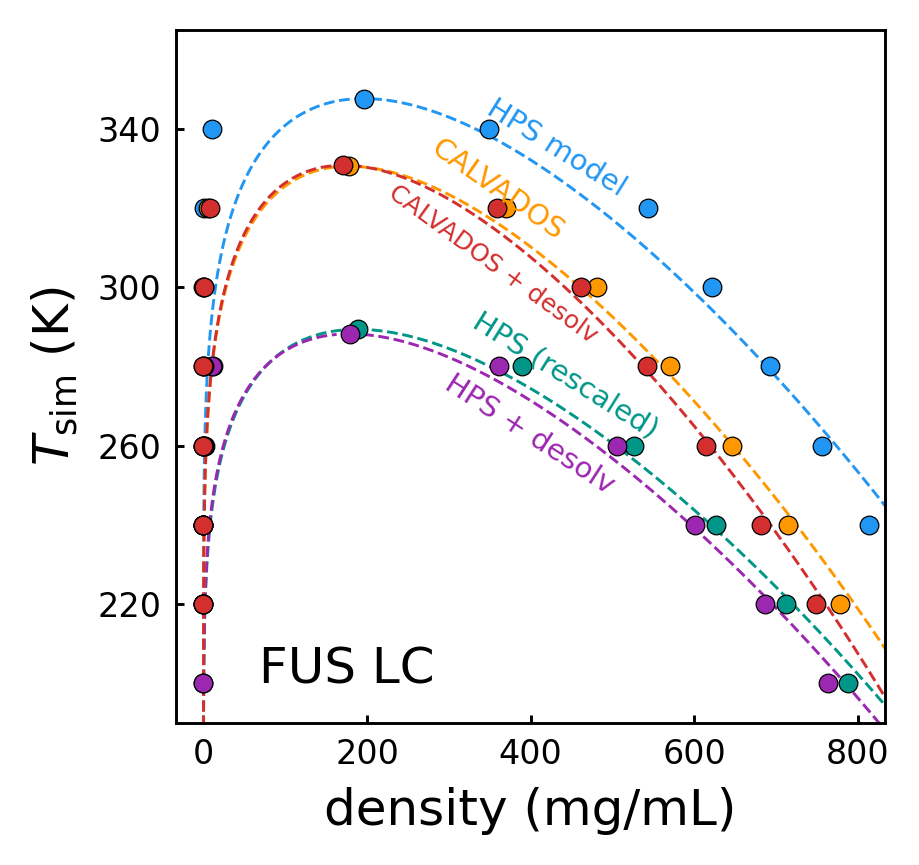

In [4]:
import sys, os, numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
import matplotlib.cm as cm
import pandas as pd

def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

protein = 'FUS'
options = ['hps', 'HPS_0.16', 'des_0.2_0.066_0.012', 'CALVADOS', 'CAL_0.262_0.0786_0.00786']

fig, ax = plt.subplots(1, 1, figsize=[3.05, 3], facecolor='w', dpi=300)
clist = ['#2196F3', '#009688', '#9C27B0', '#FF9800', '#D32F2F']

## Plot density profile
for ci in range(len(options)):

    option = options[ci]
    data_folder = 'data/{:s}/{:s}/'.format(protein, option)
    RHO_H, RHO_L, T = [], [], []
    for temp in range(200, 360, 10):
        simulation_T = str(temp)
        traj_folder = 'traj/{:s}/{:s}/{:s}/'.format(protein, option, simulation_T)
        if not os.path.exists(traj_folder):
            continue
        u = mda.Universe(traj_folder + simulation_T + '.gsd', traj_folder + simulation_T + '.dcd')
        nlen = len(u.trajectory)
        natoms = u.atoms.n_atoms
        mass = u.atoms.masses
        name = u.atoms.names
        box = u.dimensions
        lenx, leny, lenz = box[0], box[1], box[2]
        zmax, zmin = lenz / 2, - lenz / 2
        nbins = 500
        nres = 168
        dz = lenz / nbins
        axisz = np.linspace(zmin, zmax, nbins)

        if os.path.exists(data_folder + simulation_T + '_dp.npy'):
            rhoave = np.load(data_folder + simulation_T + '_dp.npy')
        else:
            count = 0
            rhosum = np.zeros(nbins)
            for frame in np.arange(0, nlen, 1):
                if frame % 100 == 0:
                    print(frame)
                ts = u.trajectory[frame]
                cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                massz = np.zeros(nbins)
                for i in range(natoms):
                    nposz = ts.positions[i][2] - cmassz
                    nmass = mass[i]
                    idx = int((nposz - zmin) / dz)
                    if idx >= 500:
                        idx -= 500
                    if idx < 0:
                        idx += 500
                    massz[idx] += nmass
                rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                rhosum += rhoz
                count += 1
            rhoave = rhosum / count
            rhoidx = np.where(rhoave > max(rhoave) * 0.2)
            mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
            if mc_idx > 0:
                tmp = rhoave[:mc_idx].copy()
                rhoave[:-mc_idx] = rhoave[mc_idx:]
                rhoave[-mc_idx:] = tmp
            if mc_idx < 0:
                tmp = rhoave[mc_idx:].copy()
                rhoave[-mc_idx:] = rhoave[:mc_idx]
                rhoave[:-mc_idx] = tmp
            
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            np.save(data_folder + simulation_T + '_dp.npy', rhoave)
        
        rho_max = max(rhoave)
        rho_min = min(rhoave)
        rho_hd, rho_ld = 0, 0
        count_hd, count_ld = 0, 0
        for rho in rhoave:
            if rho >= rho_max * 0.95:
                rho_hd += rho
                count_hd += 1
            if rho <= rho_min + 50:
                rho_ld += rho
                count_ld += 1
        rho_hd /= count_hd
        rho_ld /= count_ld

        rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
        rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

        if abs(rho_hd - rho_ld) <= 50:
            continue

        T.append(temp)
        RHO_H.append(rho_hd)
        RHO_L.append(rho_ld)
    
    ## Plot coexistence curve
    tc_list, rhoc_list = {}, {}

    delta_rho = np.array(RHO_H) - np.array(RHO_L)
    rho_ave = (np.array(RHO_H) + np.array(RHO_L)) / 2
    T_prods = np.array(T)
    param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho))
    A, T_c = param[0]
    param = leastsq(err_rhoc, [0, 0], args=(T_prods, rho_ave))
    B, C = param[0]
    rho_c = B + C * T_c

    if option == 'hps':
        label = 'HPS'
    elif option == 'CALVADOS':
        label = 'CALVADOS 2'
        data = pd.DataFrame(columns=['conc_dil', 'conc_den'])
        for i in range(len(T)):
            data.loc[T[i]] = [RHO_L[i], RHO_H[i]]
        data.to_pickle('data/cal.pkl')
    else:
        label = 'desolvation'

    rho_fit, T_fit, rhoc = fit_FH_binodal(T, RHO_H, RHO_L, T_c, fit_chi0=False)
    plt.scatter(RHO_H, T, s=20, c=clist[ci], edgecolors='k', linewidths=0.3, zorder=10)
    plt.scatter(RHO_L, T, s=20, c=clist[ci], edgecolors='k', linewidths=0.3, zorder=10)
    plt.scatter(rhoc, T_c, s=20, c=clist[ci], edgecolors='k', linewidths=0.3, zorder=10)
    plt.plot(rho_fit, T_fit, c=clist[ci], ls='--', lw=0.7)

plt.text(340, 323, 'HPS model', color=clist[0], fontsize=7, rotation=-32, zorder=20)
plt.text(323, 262, 'HPS (rescaled)', color=clist[1], fontsize=7, rotation=-32, zorder=20)
plt.text(289, 248, 'HPS + desolv', color=clist[2], fontsize=7, rotation=-33, zorder=20)
plt.text(272, 312, 'CALVADOS', color=clist[3], fontsize=7, rotation=-35, zorder=20)
plt.text(221, 286, 'CALVADOS + desolv', color=clist[4], fontsize=6, rotation=-36, zorder=20)
plt.text(68, 200, 'FUS LC', fontsize=12)
plt.xlabel('density (mg/mL)', fontsize=12)
plt.ylabel(r'$T_\mathregular{sim}$ (K)', fontsize=12)
plt.xlim(-34, 833)
plt.ylim(190, 365)
plt.yticks([220, 260, 300, 340])
plt.tick_params(labelsize=8, direction='in', length=2, width=0.7)
for spine in ax.spines.values():
    spine.set_linewidth(0.7)

plt.savefig(f"../../figures/param/binodal.svg", format="svg", bbox_inches='tight')
plt.show()

/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(sorted(unique_bonds)), 4)
/home/swalker/.local/lib/python3.8/site-packages/MDAnalysis/core/topologyobjects.py:600: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  guessed = np.asarray(guessed, dtype=np.bool)


2.757906045121574
3.35404492030628
3.385054528449549
3.1166606806716723
3.1615750015718946


/tmp/ipykernel_3439058/401090872.py:57: RuntimeWarning: invalid value encountered in power
  return A * (Tc - T)**beta - delta_rho


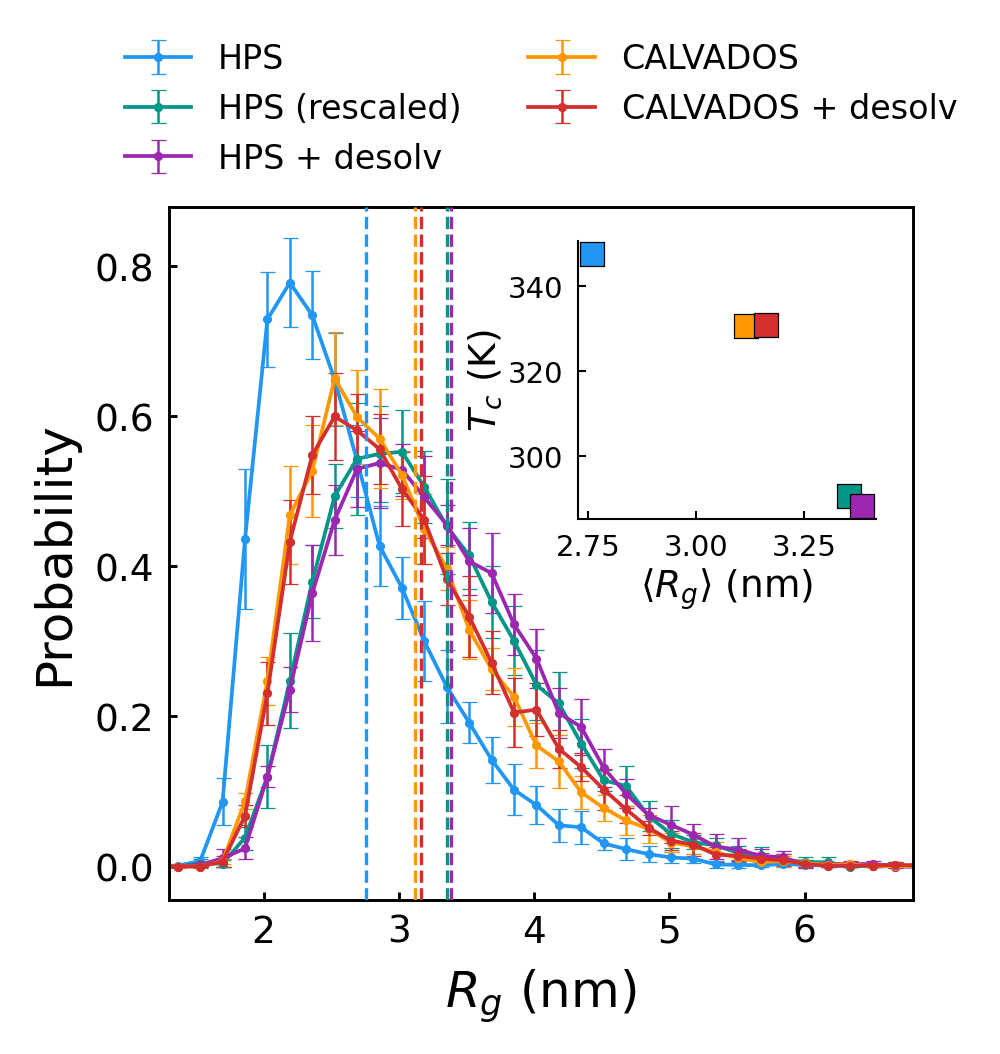

In [92]:
import os
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

def plot_rg_distribution(dir, color, label):
    nbins = 35
    dist = np.zeros((10, nbins))
    rgs = []
    for irep in range(10):
        traj_dir = f'{dir}/replica_{irep}'
        u = mda.Universe(f'{traj_dir}.gsd', f'{traj_dir}.dcd')
        chain = u.select_atoms('all')
        nlen = len(u.trajectory)
        rg = np.zeros(nlen)
        for tdx, ts in enumerate(u.trajectory):
            mda.lib.mdamath.make_whole(chain)
            rg[tdx] = chain.radius_of_gyration()
        dist[irep, :], _ = np.histogram(rg, bins=nbins, range=(1.2, 7), density=True)
        rgs.append(np.mean(rg))
    dist_avg = np.mean(dist, axis=0)
    dist_std = np.std(dist, axis=0)
    bins = np.linspace(1.2, 7, nbins+1)
    ax.errorbar(bins[:-1], dist_avg, yerr=dist_std, color=color, fmt='-o', linewidth=0.9, markersize=1.2, capsize=1.8, capthick=0.3, elinewidth=0.6, label=label)
    rg_avg = np.sum(dist_avg * bins[:-1])/np.sum(dist_avg)
    rg_avg = np.mean(rgs)
    print(rg_avg)
    ax.axvline(rg_avg, color=color, linestyle='--', lw=0.8, zorder=100)
    return rg_avg

HPS_dir = '../rg/traj/FUS/HPS'
HPS_scale_dir = '../rg/traj/FUS/HPS_0.16'
HPSdes_dir = '../rg/traj/FUS/HPS_0.33_0.06_1.0'
CALVADOS_dir = '../rg/traj/FUS/CALVADOS'
CALVADOSdes_dir = '../rg/traj/FUS/CALVADOS_0.3_0.03_1.31'
labels = ['HPS', 'HPS (rescaled)', 'HPS + desolv', 'CALVADOS', 'CALVADOS + desolv']

fig, ax = plt.subplots(1, 1, figsize=[3.2, 3], facecolor='w', dpi=300)
clist = ['#2196F3', '#009688', '#9C27B0', '#FF9800', '#D32F2F']
Rg_list = []
for i, traj_dir in enumerate([HPS_dir, HPS_scale_dir, HPSdes_dir, CALVADOS_dir, CALVADOSdes_dir]):
    rg_avg = plot_rg_distribution(traj_dir, clist[i], labels[i])
    Rg_list.append(rg_avg)
plt.legend(fontsize=8, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.28), frameon=False)
plt.xlim(1.3, 6.8)
plt.xlabel(r'$R_g$ (nm)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.tick_params(labelsize=9, direction='in', length=2, width=0.7)
for spine in ax.spines.values():
    spine.set_linewidth(0.7)

# rg vs. tc
def err_Tc(param, T, delta_rho):
    A, Tc = param
    beta = 0.325
    return A * (Tc - T)**beta - delta_rho

def err_rhoc(param, T, rho_ave):
    B, C = param
    return rho_ave - (B + C * T)

Tc_list = []
slab_folders = ['hps', 'HPS_0.16', 'des_0.2_0.066_0.012','CALVADOS', 'CAL_0.262_0.0786_0.00786']
for i, slab_folder in enumerate(slab_folders):
    data_folder = f'data/FUS/{slab_folder}'
    RHO_H, RHO_L, T = [], [], []
    for temp in range(200, 360, 10):
        traj_folder = f'traj/FUS/{slab_folder}/{temp}'
        if not os.path.exists(traj_folder):
            continue
        u = mda.Universe(f'{traj_folder}/{temp}.gsd', f'{traj_folder}/{temp}.dcd')
        nlen = len(u.trajectory)
        natoms = u.atoms.n_atoms
        mass = u.atoms.masses
        name = u.atoms.names
        box = u.dimensions
        lenx, leny, lenz = box[0], box[1], box[2]
        zmax, zmin = lenz / 2, - lenz / 2
        nbins = 500
        nres = 168
        dz = lenz / nbins
        axisz = np.linspace(zmin, zmax, nbins)

        if os.path.exists(f'{data_folder}/{temp}_dp.npy'):
            rhoave = np.load(f'{data_folder}/{temp}_dp.npy')
        else:
            count = 0
            rhosum = np.zeros(nbins)
            for frame in np.arange(0, nlen, 1):
                if frame % 100 == 0:
                    print(frame)
                ts = u.trajectory[frame]
                cmassz = sum(ts.positions[:, 2] * mass) / sum(mass)
                massz = np.zeros(nbins)
                for i in range(natoms):
                    nposz = ts.positions[i][2] - cmassz
                    nmass = mass[i]
                    idx = int((nposz - zmin) / dz)
                    if idx >= 500:
                        idx -= 500
                    if idx < 0:
                        idx += 500
                    massz[idx] += nmass
                rhoz = massz / (lenx * leny * dz * 6.02214e-1)
                rhosum += rhoz
                count += 1
            rhoave = rhosum / count
            rhoidx = np.where(rhoave > max(rhoave) * 0.2)
            mc_idx = int(np.mean(rhoidx) - len(rhoave) / 2)
            if mc_idx > 0:
                tmp = rhoave[:mc_idx].copy()
                rhoave[:-mc_idx] = rhoave[mc_idx:]
                rhoave[-mc_idx:] = tmp
            if mc_idx < 0:
                tmp = rhoave[mc_idx:].copy()
                rhoave[-mc_idx:] = rhoave[:mc_idx]
                rhoave[:-mc_idx] = tmp
            
            if not os.path.exists(data_folder):
                os.makedirs(data_folder)
            np.save(f'{data_folder}/{temp}_dp.npy', rhoave)
        
        rho_max = max(rhoave)
        rho_min = min(rhoave)
        rho_hd, rho_ld = 0, 0
        count_hd, count_ld = 0, 0
        for rho in rhoave:
            if rho >= rho_max * 0.95:
                rho_hd += rho
                count_hd += 1
            if rho <= rho_min + 50:
                rho_ld += rho
                count_ld += 1
        rho_hd /= count_hd
        rho_ld /= count_ld

        rho_hd = np.average(rhoave[int(nbins/2-5):int(nbins/2+5)])
        rho_ld = (np.average(rhoave[:180]) + np.average(rhoave[-180:])) / 2

        if abs(rho_hd - rho_ld) <= 50:
            continue
        
        rho_hd /= np.sum(mass[:168]) * 1e-3
        rho_ld /= np.sum(mass[:168]) * 1e-3

        T.append(temp)
        RHO_H.append(rho_hd)
        RHO_L.append(rho_ld)

    tc_list, rhoc_list = {}, {}

    delta_rho = np.array(RHO_H) - np.array(RHO_L)
    rho_ave = (np.array(RHO_H) + np.array(RHO_L)) / 2
    T_prods = np.array(T)
    param = leastsq(err_Tc, [100, 400], args=(T_prods, delta_rho))
    A, T_c = param[0]
    Tc_list.append(T_c)

axin = ax.inset_axes([0.55, 0.55, 0.4, 0.4])
for i in range(len(Rg_list)):
    axin.scatter(Rg_list[i], Tc_list[i], marker='s', s=35, edgecolors='k', linewidths=0.3, color=clist[i], zorder=3)
axin.set_xlabel(r'$\langle R_g\rangle$ (nm)', fontsize=9, labelpad=1)
axin.set_ylabel(r'$T_c$ (K)', fontsize=9, labelpad=1)
axin.tick_params(labelsize=7, direction='in', length=2, width=0.5)
for spine in axin.spines.values():
    spine.set_linewidth(0.5)
axin.spines['top'].set_visible(False)
axin.spines['right'].set_visible(False)